In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 118.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import the pytorch library into environment and check its version
import os
import torch
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, ChebConv, GraphConv

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.utils import stochastic_blockmodel_graph
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import networkx as nx
import pickle
from scipy.sparse import csr_matrix, save_npz, load_npz
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.loader import NeighborSampler
import torch.nn as nn



print("Using torch", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}")

Using torch 2.1.0+cu118
Device is cuda


# 1. Data Preparation

In [ ]:
adj_matrix = load_npz("/content/drive/MyDrive/Colab Notebooks/adj_matrix.npz")
with open('/content/drive/MyDrive/Colab Notebooks/cluster_id.pkl', 'rb') as file:
      cluster_ids = pickle.load(file)
cluster_ids = torch.Tensor(cluster_ids)

feature_size = 512
num_classes = len(torch.unique(cluster_ids))
num_nodes = adj_matrix.shape[0]


# x = torch.randn((num_nodes, feature_size))  # random feature
x = torch.Tensor(np.load(f"/content/drive/MyDrive/Colab Notebooks/embedding_{feature_size}.npy")) # augmented feature
y = cluster_ids  

edge_index, _ = from_scipy_sparse_matrix(adj_matrix)

## Train, Validation, Test Split

In [5]:
train_size = int(num_nodes * 0.7)
val_size = int(num_nodes * 0.15)
test_size = num_nodes - train_size - val_size

indices = np.arange(num_nodes)
np.random.shuffle(indices)
train_idx = torch.tensor(indices[:train_size], dtype=torch.long)
val_idx = torch.tensor(indices[train_size:train_size + val_size], dtype=torch.long)
test_idx = torch.tensor(indices[train_size + val_size:], dtype=torch.long)

BATCH_SIZE = 256
train_loader = NeighborSampler(edge_index, node_idx=train_idx, sizes=[10, 10], batch_size=BATCH_SIZE, shuffle=True)
val_loader = NeighborSampler(edge_index, node_idx=val_idx, sizes=[10, 10], batch_size=BATCH_SIZE, shuffle=False)
test_loader = NeighborSampler(edge_index, node_idx=test_idx, sizes=[10, 10], batch_size=BATCH_SIZE, shuffle=False)

# 2. Model Construction

In [6]:
# Step 2: Define a 2-layer GCN

class GCN(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.convs = nn.ModuleList([
            GraphConv(num_features, hidden_size),
            GraphConv(hidden_size, hidden_size)
        ])
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.prediction_head = nn.Linear(hidden_size, num_classes)

    def forward(self, x, adjs, return_embedding=False):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]
            x = self.convs[i]((x, x_target), edge_index)
            if return_embedding and i == len(adjs) - 1:
                return x 
            if i != len(adjs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)

        x = self.prediction_head(self.linear(x))  
        return x

class GAT(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, heads=8, dropout=0.5):
        super(GAT, self).__init__()
        self.convs = nn.ModuleList([
            GATConv(num_features, hidden_size, heads=heads, dropout=dropout),
            GATConv(hidden_size * heads, hidden_size, heads=1,concat=False, dropout=dropout)
        ])
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.prediction_head = nn.Linear(hidden_size, num_classes)

    def forward(self, x, adjs, return_embedding=False):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]
            x = self.convs[i]((x, x_target), edge_index)

            if i != len(adjs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        if return_embedding:
                return x

        x = F.relu(self.linear(x))
        x = self.prediction_head(x) 
        return x

# 3. Model Training
## Define the model

In [ ]:
hidden_size = 512
model = GCN(feature_size, hidden_size, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Training

Epoch 1/100, Train Loss: 10.3987, Train Acc: 0.9531 | Validation Loss: 28.6027, Validation Acc: 0.9944
Epoch 2/100, Train Loss: 9.8061, Train Acc: 0.9653 | Validation Loss: 0.0574, Validation Acc: 0.9955
Epoch 3/100, Train Loss: 0.8964, Train Acc: 0.9666 | Validation Loss: 0.0374, Validation Acc: 0.9956
Epoch 4/100, Train Loss: 0.3749, Train Acc: 0.9677 | Validation Loss: 0.0609, Validation Acc: 0.9953
Epoch 5/100, Train Loss: 0.3192, Train Acc: 0.9670 | Validation Loss: 0.0306, Validation Acc: 0.9953
Epoch 6/100, Train Loss: 0.3387, Train Acc: 0.9677 | Validation Loss: 0.0678, Validation Acc: 0.9953
Epoch 7/100, Train Loss: 0.2304, Train Acc: 0.9696 | Validation Loss: 0.0459, Validation Acc: 0.9955
Epoch 8/100, Train Loss: 0.2400, Train Acc: 0.9693 | Validation Loss: 0.0191, Validation Acc: 0.9961
Epoch 9/100, Train Loss: 0.2401, Train Acc: 0.9691 | Validation Loss: 0.0247, Validation Acc: 0.9961
Epoch 10/100, Train Loss: 0.2582, Train Acc: 0.9652 | Validation Loss: 0.0284, Validation

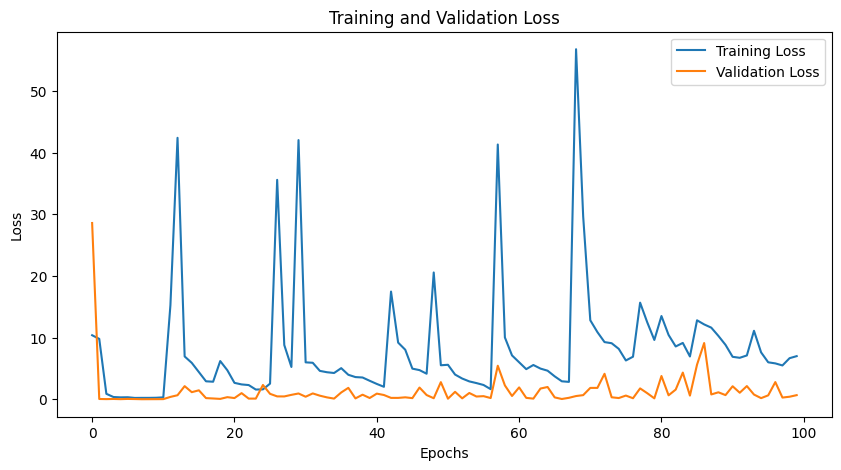

In [7]:
# Step 4: Train the GNN

def train(loader):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_size, n_id, adjs in loader:
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()
        out = model(x[n_id].to(device), adjs)
        labels = y[n_id[:batch_size]].to(device).long()
        loss = F.cross_entropy(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(loader), accuracy

def validate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_size, n_id, adjs in loader:
            adjs = [adj.to(device) for adj in adjs]
            out = model(x[n_id].to(device), adjs)
            labels = y[n_id[:batch_size]].to(device).long()
            loss = F.cross_entropy(out, labels)
            total_loss += loss.item()
            _, predicted = torch.max(out.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(loader), accuracy


# Training and validation process
train_losses, val_losses = [], []
num_epochs = 100  # Set the number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train(train_loader)
    val_loss, val_acc = validate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# 4. Extract Embeddinng and Prediction

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
def extract_embeddings(loader):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch_size, n_id, adjs in loader:
            # adjs = [(edge_index.to(device), size) for edge_index, size in adjs]
            adjs = [(adjs[0].to(device), adjs[1], adjs[-1])]
            out = model(x[n_id].to(device), adjs, return_embedding=True)
            embeddings.append(out.cpu())
    return torch.cat(embeddings, dim=0)

full_loader = NeighborSampler(edge_index, node_idx=None, sizes=[-1], batch_size=1024, shuffle=False)
embeddings = extract_embeddings(full_loader)

In [13]:
def get_predictions(loader):
    model.eval()
    predictions = []
    logits_list = []
    with torch.no_grad():
        for batch_size, n_id, adjs in loader:
            adjs = [(adjs[0].to(device), adjs[1], adjs[-1])]
            logits = model(x[n_id].to(device), adjs, return_embedding=False)

            predicted_classes = logits.argmax(dim=-1)
            predictions.append(predicted_classes.cpu())
            logits_list.append(logits.cpu())
    return torch.cat(predictions, dim=0), torch.cat(logits_list, dim=0)

# Obtain predictions
full_loader = NeighborSampler(edge_index, node_idx=None, sizes=[-1], batch_size=1024, shuffle=False)
predictions, logits = get_predictions(full_loader)


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    metrics = {}
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['Recall'] = recall_score(y_true, y_pred, average='weighted')
    metrics['F1 Score'] = f1_score(y_true, y_pred, average='weighted')


    return metrics

metrics = evaluate_classification_metrics(y, predictions)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value}")



Accuracy: 0.19039285498762898
Precision: 0.07555599733475483
Recall: 0.19039285498762898
F1 Score: 0.06310939084088406


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Visualization

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(embeddings.numpy())
embeddings_2d = reduced_data
# tsne = TSNE(n_components=2)
# embeddings_2d = tsne.fit_transform(reduced_data)


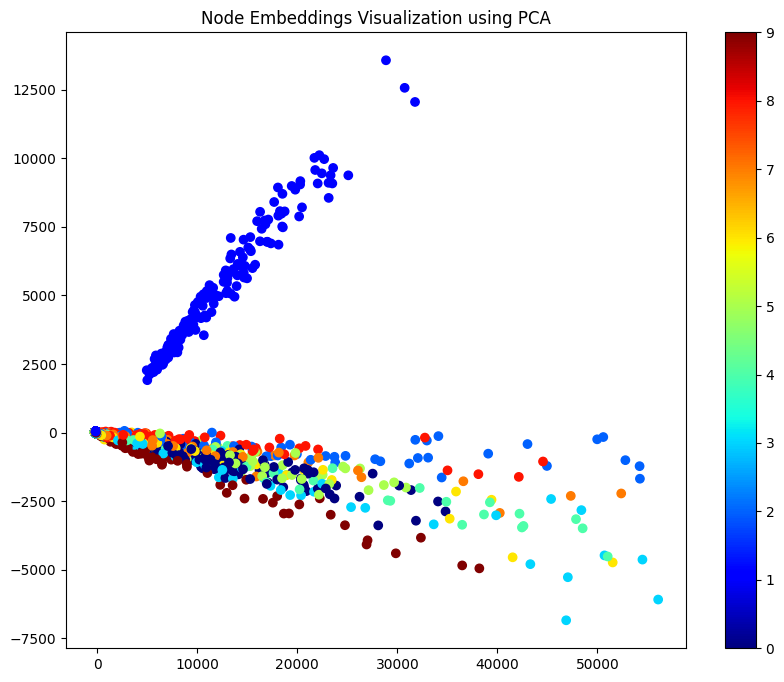

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y.numpy(), cmap='jet')
plt.colorbar()
plt.title('Node Embeddings Visualization using PCA')
plt.show()